<a href="https://colab.research.google.com/github/MachineSaver/MachineSaver/blob/main/AirVibe_Overall_Data_Integration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Sign Up For an Account @ [https://url.machinesaver.com/airvibe_activation](https://url.machinesaver.com/airvibe_activation)
# 2. Scan QR code to claim an AirVibe

# 3. Programmatically Retrieve LoRa Credentials

In [ ]:
import json
import requests

In [ ]:
def get_auth_token(login: str, password: str) -> str:
  """Login to Machine Saver Activation API and retrieve access token."""
  url = "https://ap-api.wipom.net/api/auth/login"
  headers = {'Content-Type': 'application/json'}
  data = json.dumps({'login': login, 'password': password})

  response = requests.post(url, headers=headers, data=data)

  if response.status_code == 200:
    token_data = response.json()
    access_token = token_data['data']['accessToken']
    print(access_token)
    return access_token
  else:
    print(f"Failed to login: {response.status_code} - {response.text}")
    return None


In [ ]:
access_token = get_auth_token(login="activation_portal_login", password="activation_portal_pass")

Failed to login: 400 - {"data":null,"id":"334370a6-3282-4074-a0ad-6363ff068651","timestamp":"2025-03-13T18:13:20.6980922Z","message":"Login / password information are incorrect.","success":false}


In [ ]:
def get_with_EUI_AC(dev_eui: str, access_code: str, access_token: str) -> dict:
    """Get tags list for a specific device from Machine Saver API."""
    url = f"https://ap-api.wipom.net/api/devices/search?eui={dev_eui}&ac={access_code}"
    headers = {'Authorization': f'Bearer {access_token}'}

    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"Failed to fetch tag list: {response.status_code} - {response.text}")
        return None

In [ ]:
get_with_EUI_AC(dev_eui="8C1F642113000017", access_code="74475383", access_token=access_token)

{'data': [{'serial': '3000017',
   'devEUI': '8C-1F-64-21-13-00-00-17',
   'appEUI': '8C1F64211FFFFFFF',
   'appKey': '07E80716143027BDDAB969DA698B124C',
   'fPort': 0,
   'activationCode': '74475383',
   'accountId': 17,
   'type': 'LoRaWAN',
   'name': '3000017',
   'partNumber': 'WB-L-1',
   'firmwareVersion': '1.01',
   'createDate': '2024-08-22T20:48:41.305156Z',
   'password': '',
   'imei': '',
   'macAddress': '',
   'netAddressList': '',
   'bipomSerial': '',
   'isClaimed': False,
   'claimAccountId': 0}],
 'id': '05d3851b-4d36-4a23-9dd4-ef95bb429ba4',
 'timestamp': '2025-03-13T18:18:20.1930383Z',
 'message': '',
 'success': True}

In [ ]:
def get_with_serial(serial: str, access_token: str) -> dict:
    """Get data for a specific device from Machine Saver API."""
    url = f"https://ap-api.wipom.net/api/devices/serial?pattern={serial}"
    headers = {'Authorization': f'Bearer {access_token}'}

    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"Failed to fetch: {response.status_code} - {response.text}")
        return None

In [ ]:
get_with_serial(serial="3000017", access_token=access_token)

{'data': [{'serial': '3000017',
   'devEUI': '8C-1F-64-21-13-00-00-17',
   'appEUI': '8C1F64211FFFFFFF',
   'appKey': '07E80716143027BDDAB969DA698B124C',
   'fPort': 0,
   'activationCode': '74475383',
   'accountId': 17,
   'type': 'LoRaWAN',
   'name': '3000017',
   'partNumber': 'WB-L-1',
   'firmwareVersion': '1.01',
   'createDate': '2024-08-22T20:48:41.305156Z',
   'password': '',
   'imei': '',
   'macAddress': '',
   'netAddressList': '',
   'bipomSerial': '',
   'isClaimed': False,
   'claimAccountId': 0}],
 'id': 'bc4f5c0f-d4b1-487a-b61e-dbc263f60e0d',
 'timestamp': '2025-03-13T18:18:21.8785765Z',
 'message': '',
 'success': True}

# 4. Wake Up AirVibe
# 5. Decode Overall LoRa Packets

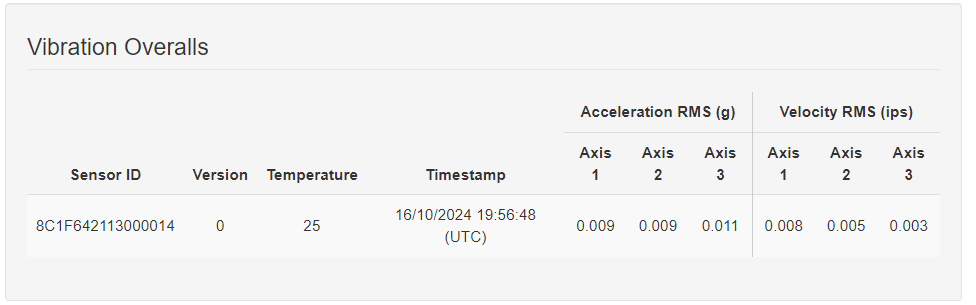

* BYTE 00 : Type (1 - Timewave, 2 - Overall)
* BYTE 01 : Status (0 - OK, not 0 - error)
* BYTE 02 : Firmware Revision  (always 0 for now)
* BYTE 03 : Temperature
* BYTE 04 : Humidity (always 0 for now)
* BYTE 05 : Battery
* BYTE 06 : Supply Voltage  (always 0 for now)
* BYTE 07 - 08 :  Acceleration X
* BYTE 09 - 10 :  Acceleration Y
* BYTE 11 - 12 :  Acceleration Z
* BYTE 13 - 14 :  Velocity X
* BYTE 15 - 16 :  Velocity Y
* BYTE 16 - 17 :  Velocity Z

In [ ]:
import struct
import numpy as np

def decode_payload(payload_hex):
    # Convert hex string to bytes
    payload_bytes = bytes.fromhex(payload_hex.replace(" ", ""))

    # Unpack the data
    type_byte, status, firmware_rev, temperature, humidity, battery, supply_voltage = struct.unpack('>BBBBBBB', payload_bytes[:7])
    acc_x, acc_y, acc_z, vel_x, vel_y, vel_z = struct.unpack('>HHHHHH', payload_bytes[7:19])

    # Convert acceleration and velocity to float and divide by 1000
    float_values = [np.float16(v).astype(np.float32) / 1000 for v in [acc_x, acc_y, acc_z, vel_x, vel_y, vel_z]]

    # Create a dictionary with the decoded values
    decoded = {
        'Type': 'Timewave' if type_byte == 1 else 'Overall' if type_byte == 2 else 'Unknown',
        'Status': 'OK' if status == 0 else f'Error ({status})',
        'Firmware Revision': firmware_rev,
        'Temperature': temperature,
        'Humidity': humidity,
        'Battery': battery,
        'Supply Voltage': supply_voltage,
        'Acceleration_Axis_1': float_values[0],
        'Acceleration_Axis_2': float_values[1],
        'Acceleration_Axis_3': float_values[2],
        'Velocity_Axis_1': float_values[3],
        'Velocity_Axis_2': float_values[4],
        'Velocity_Axis_3': float_values[5]
    }

    return decoded

# Example usage
payload = "02 00 00 19 00 64 00 00 09 00 09 00 0B 00 08 00 05 00 03"
result = decode_payload(payload)

for key, value in result.items():
    print(f"{key}: {value}")